In [1]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

array([[ 0.83103915, -0.25874875,  1.        ],
       [ 1.18506381,  0.92038714,  0.        ],
       [ 1.16402213, -0.45552558,  1.        ],
       ...,
       [ 0.1823981 ,  0.02966123,  1.        ],
       [ 1.26017313, -0.58921704,  1.        ],
       [-0.02664926,  1.58396005,  0.        ]])

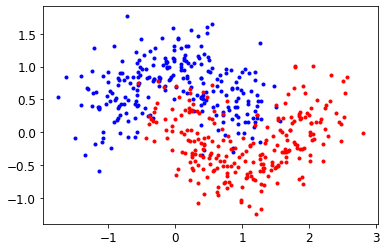

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

indecies_0 = np.where(y == 0)
indecies_1 = np.where(y == 1)

np.c_[X, y]
#X[:,0:1]
plt.plot(X[indecies_0][:,0:1], X[indecies_0][:,1:], 'b.')
plt.plot(X[indecies_1][:,0:1], X[indecies_1][:,1:], 'r.')

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [44]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression()

LogisticRegression 0.864


RandomForestClassifier()

RandomForestClassifier 0.896


SVC()

SVC 0.896


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

VotingClassifier 0.904


In [48]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [49]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression()

LogisticRegression 0.864


RandomForestClassifier()

RandomForestClassifier 0.904


SVC(probability=True)

SVC 0.896


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

VotingClassifier 0.92


In [208]:
def yToOutput(y):
    n_classes = y.max() + 1
    m = len(y)
    ny = np.zeros((m, n_classes))
    ny[np.arange(m), y] = 1
    return ny

In [211]:
y_p = yToOutput(y_train)

In [221]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

class MyPolynomialPredictor:
    def __init__(self, degree = 1, start = 0, eta = 0.05, a = 0, epsilon = 1e-7):
        self.theta = np.random.randn(degree + 1, 2)
        self.epsilon = epsilon
        self.a = a
        self.eta = eta
        self.start = start
        self.degree = degree;

    def transform(self, X):
        m = len(X)
        x = np.c_[np.ones((m, 1)), X[:,self.start : self.start + self.degree]]
        return x

    def fit(self, _X, y, n_iterations = 50):
        m = len(_X)
        X = self.transform(_X)

        #print(np.zeros([1, self.degree]), self.a * self.theta[1:]])
        #print(np.r_[np.zeros([1, self.degree]), self.a * self.theta[1:]])
        for iteration in range(n_iterations):
            logits = X.dot(self.theta)
            Y_proba = softmax(logits)
            #np.r_[np.zeros([1, self.degree]), self.a * self.theta[1:]]
            loss = -np.mean(np.sum(y * np.log(Y_proba + self.epsilon), axis=1))
            if(iteration % int(n_iterations / 10) == 0):
                print(iteration, loss)
            gradient = 1 / m * X.T.dot(Y_proba - y)  + np.r_[np.zeros([1, 2]), self.a * self.theta[1:]]
            #print(y, gradient)
            self.theta = self.theta - self.eta * gradient
    
    def predict(self, _X):
        X = self.transform(_X)
        return softmax(X.dot(self.theta))


In [233]:
f1 = MyPolynomialPredictor(degree = 2)
f1.fit(X_train, y_p, 1000)

y_proba = softmax(f1.predict(X_test))
y_predict = np.argmax(y_proba, axis=1)
#y_train[:30]

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0 0.7636286183296694
100 0.5588623139504393
200 0.5349921062694826
300 0.5289707854664263
400 0.5268137428140985
500 0.5260963819072969
600 0.5258734753665645
700 0.5258069805143303
800 0.5257875961493479
900 0.5257820163406085


0.744